Saint Lucia is a independent country in the Caribbean Sea and has a population of 174,000 (2010). Its capital is Castries. Saint Lucia may face the following natural hazards:
* 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
# import contextily as ctx
from analysis import *

## Specify parameters

First we need to specify the paths to the experiment results. The structure of `experiments` folder is as folows. First goes the `country` name, then `state` or `district` name, then the name of the `policy` and finally `scenario`.

In [3]:
country = 'Saint Lucia'
districts = next(os.walk(f'../experiments/{country}'))[1]
policies = next(os.walk(f'../experiments/{country}/{districts[0]}'))[1]
scenarios = next(os.walk(f'../experiments/{country}/{districts[0]}/{policies[0]}'))[1]
with open(f'../experiments/{country}/{districts[0]}/{policies[0]}/{scenarios[0]}/parameters.json') as f:
    parameters = json.load(f)
n_replications = parameters['n_replications']

print(f'Country: {country}')
print(f'Districts: {districts}')
policies = ['None']
print(f'Policies: {policies}')
print(f'Scenarios: {scenarios}')
print(f'Replications: {n_replications}')

Country: Saint Lucia
Districts: ['AnseLaRayeCanaries', 'Castries', 'Choiseul', 'Dennery', 'Gros Islet', 'Laborie', 'Micoud', 'Soufriere', 'Vieuxfort']
Policies: ['None']
Scenarios: ['100']
Replications: 200


## Load data

Now we can load the files of interest.

In [4]:
experiments = load_experiments(districts, policies, scenarios, country, n_replications)

AnseLaRayeCanaries's PML: 1,282,936
Castries's PML: 31,062,668
Choiseul's PML: 1,111,848
Dennery's PML: 2,667,414
Gros Islet's PML: 10,932,608
Laborie's PML: 2,035,118
Micoud's PML: 4,766,542
Soufriere's PML: 1,679,254
Vieuxfort's PML: 4,264,030


In [6]:
# Structure of the outcomes dataframe:
# scenario -> policy -> district -> replication -> outcome

## Prepare outcomes

In [5]:
n_years = 10 # 
max_years = 10 # 
l = [] # a list to store the outcomes per replication

statistics = {}

for scenario in scenarios:
    for policy in policies:
        for district in districts:
            statistics[district] = {}
            no_affected_households = 0
            n_resilience_more_than_1 = 0
            zero_consumption_loss = 0
            for replication in range(n_replications):
                # Get the district households of a given replication           
                households = experiments[district][policy][scenario][replication]
                total_population = households['popwgt'].sum()
                affected_households = households[households['is_affected'] == True]
                n_affected_households = affected_households['popwgt'].sum()
                annual_average_consumption = (households['aeexp'] * households['popwgt']).sum() / households['popwgt'].sum()

                # * Poverty line is different across replications
                poverty_line = households['poverty_line_adjusted'].values[0]

                # Get PML, its the same across replications and stored in households
                pml = households['pml'].iloc[0]

                # * Some runs give no affected households and we will skip these
                if len(affected_households) == 0:
                    no_affected_households += 1
                    continue
                    
                # * Sometimes households are affected but they have no consumption loss
                if affected_households['consumption_loss_NPV'].sum() == 0:
                    zero_consumption_loss += 1
                    continue

                n_poor_initial, n_new_poor, poor_initial, new_poor = find_poor(households, poverty_line, n_years)
                years_in_poverty = get_people_by_years_in_poverty(new_poor, max_years)
                initial_poverty_gap, new_poverty_gap = calculate_poverty_gap(poor_initial, new_poor, poverty_line)
                annual_average_consumption_loss, annual_average_consumption_loss_pct = calculate_average_annual_consumption_loss(affected_households, n_years)
                r, n_resilience_more_than_1 = calculate_resilience(affected_households, pml, n_resilience_more_than_1)
                d = {'scenario' : scenario,
                     'policy' : policy,
                     'district' : district,
                     'replication' : replication,
                     'total_population' : total_population,
                     'n_affected_households' : n_affected_households, 
                     'annual_average_consumption' : annual_average_consumption,
                     'annual_average_consumption_loss' : annual_average_consumption_loss,
                     'annual_average_consumption_loss_pct' : annual_average_consumption_loss_pct,
                     'n_poor_initial' : n_poor_initial,
                     'n_new_poor' : n_new_poor,
                     'years_in_poverty' : years_in_poverty,
                     'initial_poverty_gap' : initial_poverty_gap,
                     'new_poverty_gap' : new_poverty_gap,
                     'r' : r}
                s = pd.Series(d, index=d.keys())
                l.append(s)
            statistics[district]['no_affected_households'] = no_affected_households
            statistics[district]['n_resilience_more_than_1'] = n_resilience_more_than_1
            statistics[district]['zero_consumption_loss'] = zero_consumption_loss
            statistics[district]['n_resilience_more_than_1_pct'] = n_resilience_more_than_1 / n_replications

statistics = pd.DataFrame(statistics).T
outcomes = pd.DataFrame(l)
outcomes.to_csv('outcomes.csv')

## Plotting

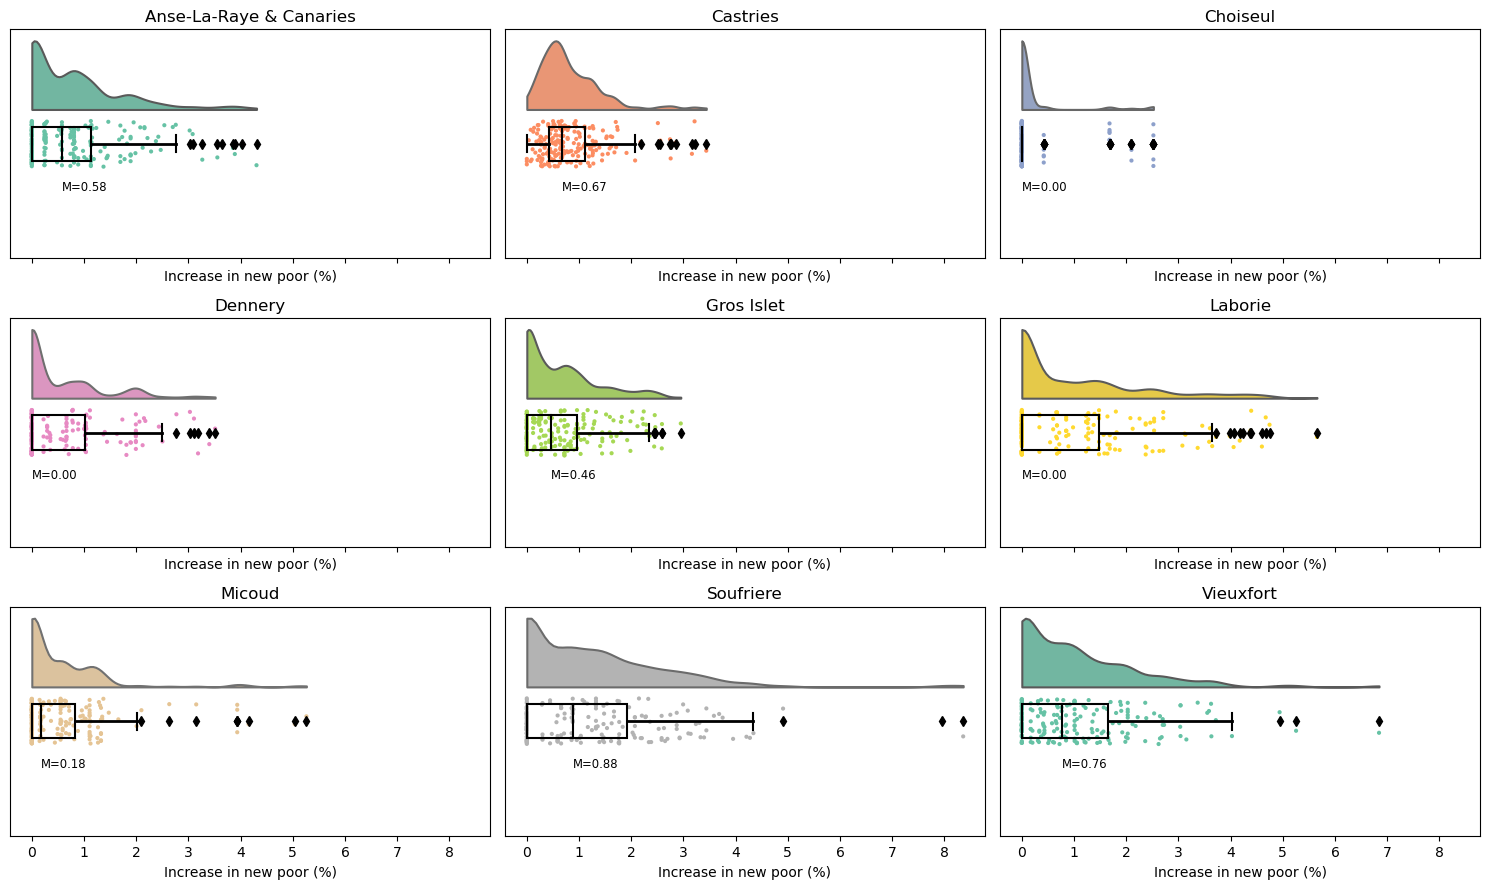

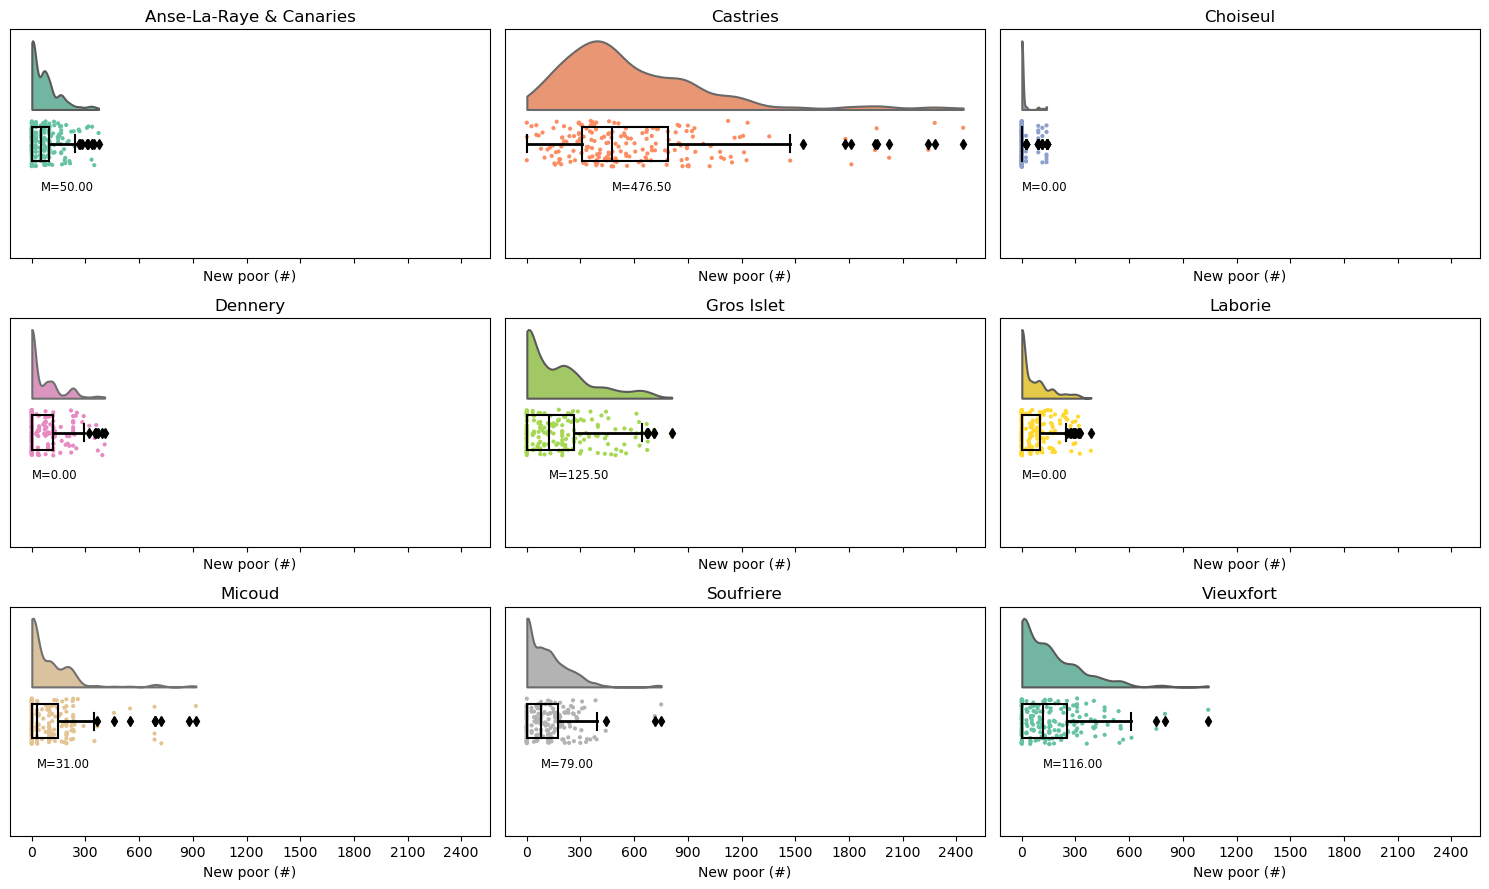

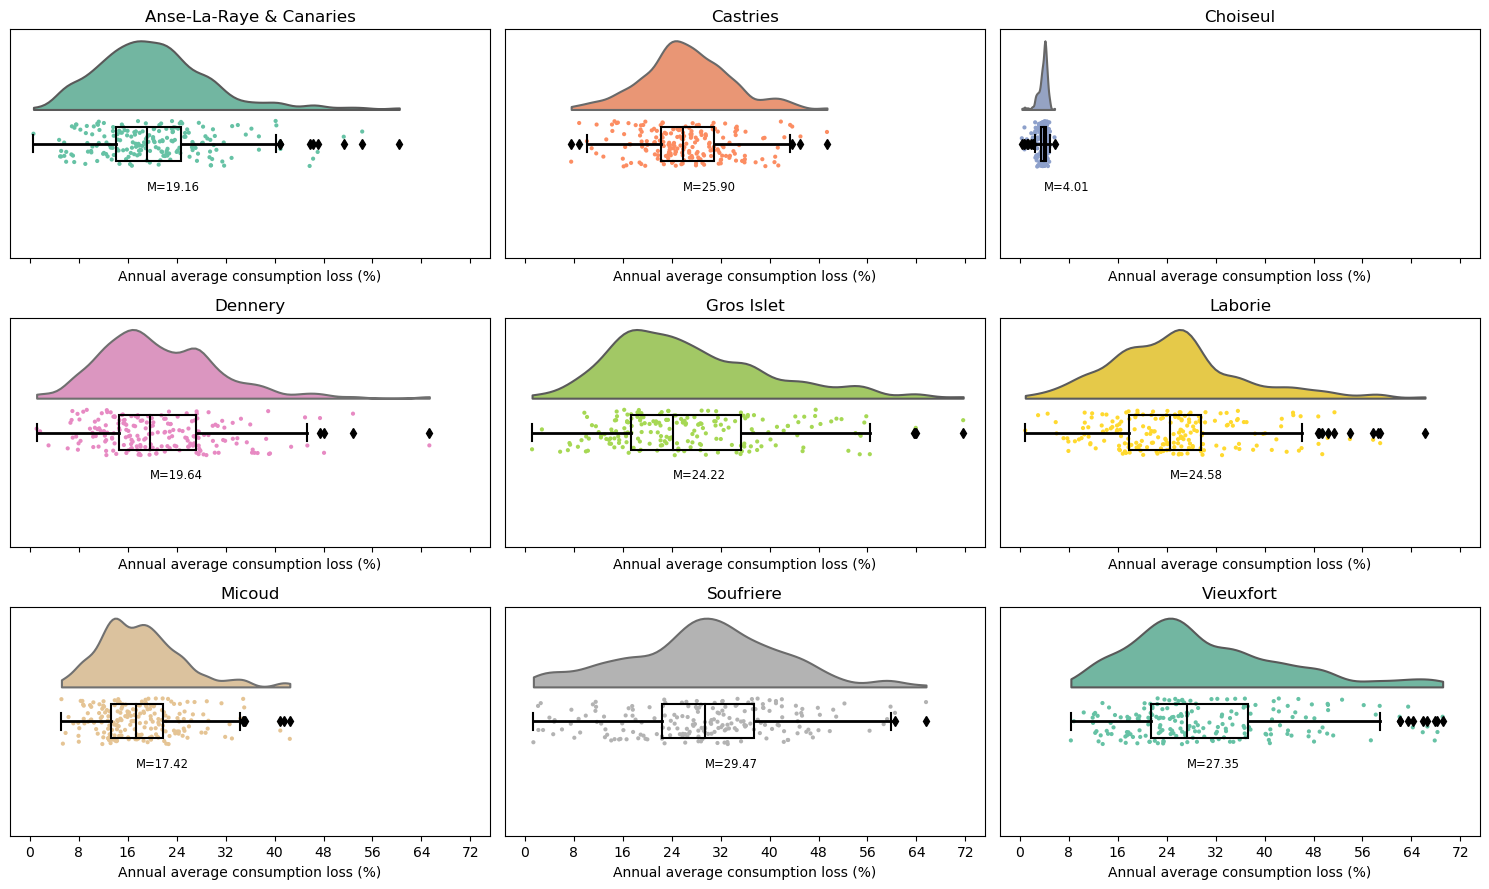

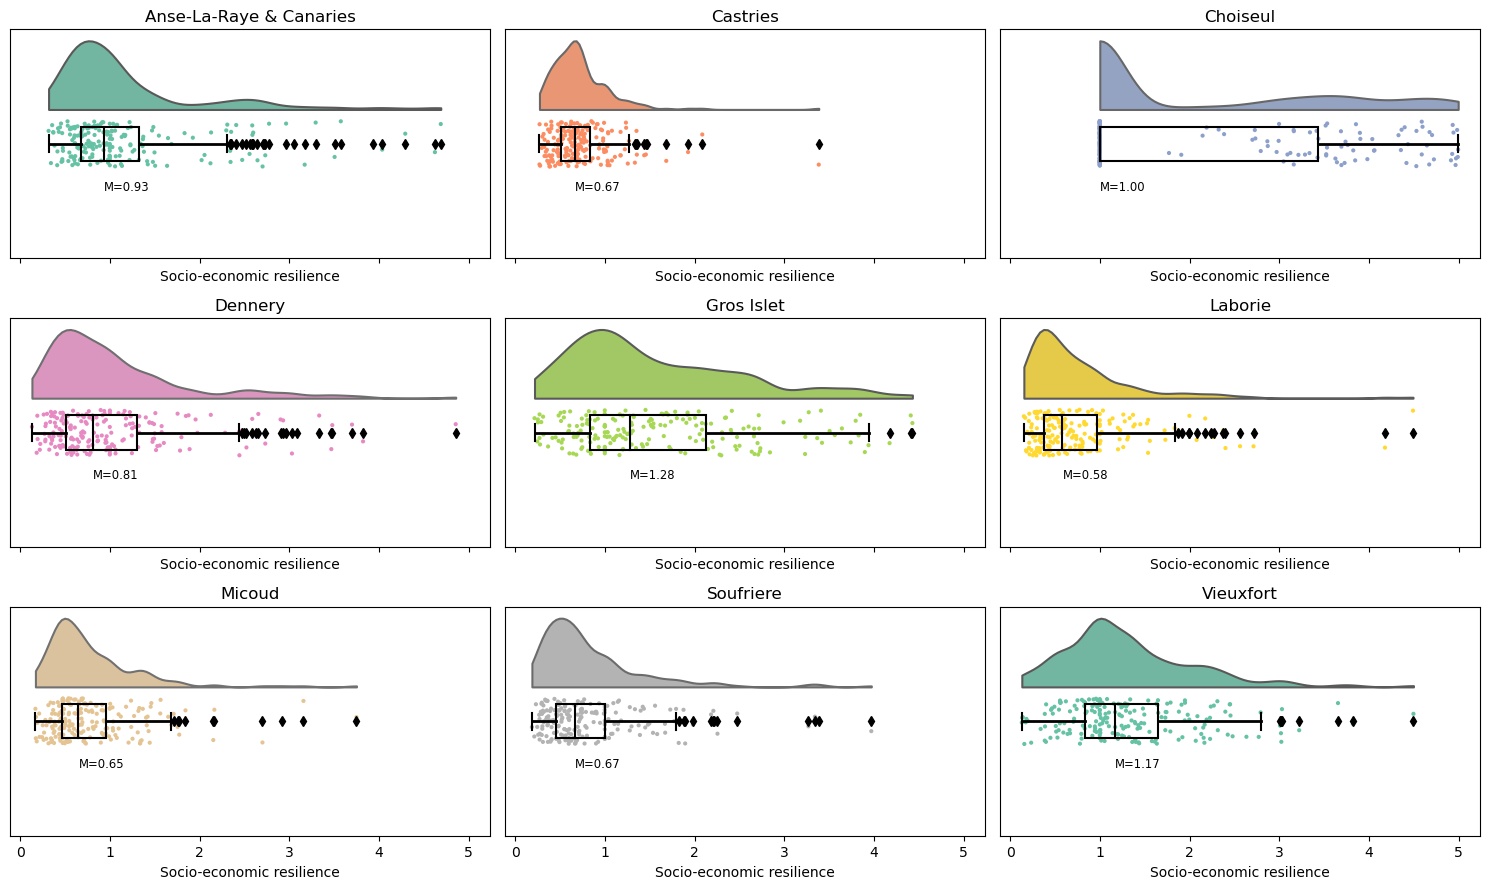

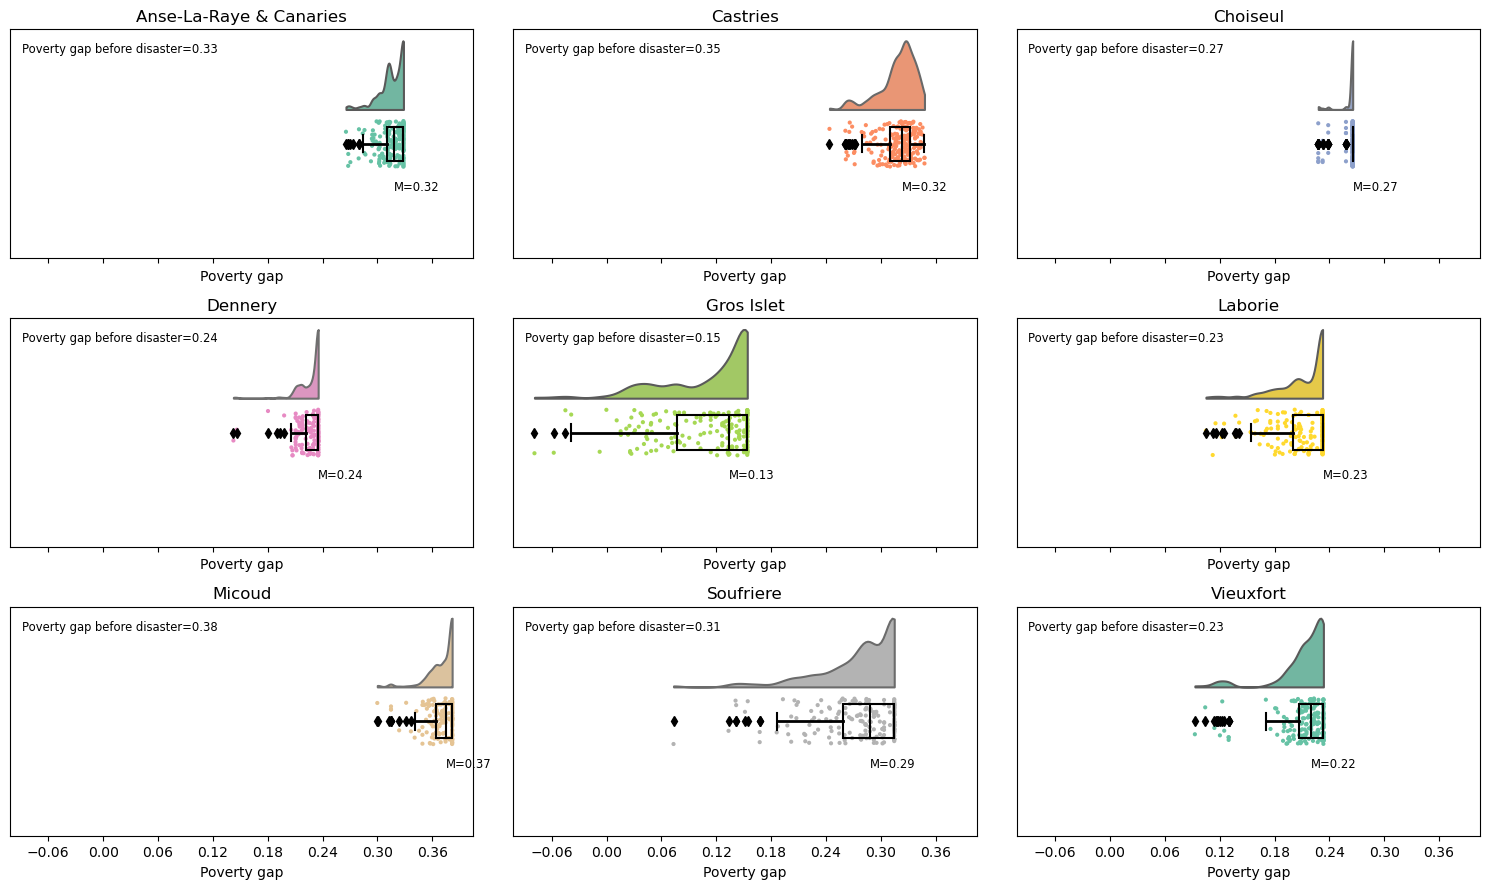

In [15]:
n_districts = len(districts)
colors = sns.color_palette('Set2', n_colors=len(districts))

x_columns = [
    'n_new_poor_increase_pct', 
    'n_new_poor', 
    'annual_average_consumption_loss_pct', 
    'r',
    'new_poverty_gap',
    # 'one_year_in_poverty',
    # 'two_years_in_poverty',
    # 'three_years_in_poverty',
    # 'four_years_in_poverty',
    # 'five_years_in_poverty',
    # 'six_years_in_poverty',
    # 'seven_years_in_poverty',
    # 'eight_years_in_poverty',
    # 'nine_years_in_poverty',
    # 'ten_years_in_poverty'
    ]
x_titles = [
    'Increase in new poor (%)', 
    'New poor (#)', 
    'Annual average consumption loss (%)', 
    'Socio-economic resilience',
    'Poverty gap'
    # 'One year in poverty',
    # 'Two years in poverty',
    # 'Three years in poverty',
    # 'Four years in poverty',
    # 'Five years in poverty',
    # 'Six years in poverty',
    # 'Seven years in poverty',
    # 'Eight years in poverty',
    # 'Nine years in poverty',
    # 'Ten years in poverty'
    ]

is_years_in_poverty = False

for x_column, x_title in zip(x_columns, x_titles):
    # if x_column == 'new_poor_increase_pct' or x_column == 'annual_average_consumption_loss_pct':
    #     sharex = True
    # else:
    #     sharex = False
    sharex = True
    fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=sharex)

    for district in districts:
        df = outcomes[outcomes['district'] == district]
        
        # Calcualte % increase in new poor in respect to the initial number of poor
        # df = df.assign(new_poor_increase_pct = df['new_poor'].div(df['poor_initial']).multiply(100))

        # Calcualte an increase in new poor in respect to the total population
        df = df.assign(n_new_poor_increase_pct = df['n_new_poor'].div(df['total_population']).multiply(100))
        df = df.assign(annual_average_consumption_loss_pct = df['annual_average_consumption_loss_pct'].multiply(100))
        df = df.assign(one_year_in_poverty = df['years_in_poverty'].apply(lambda x: x[0]))
        df = df.assign(two_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[1]))
        df = df.assign(three_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[2]))
        df = df.assign(four_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[3]))
        df = df.assign(five_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[4]))
        df = df.assign(six_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[5]))
        df = df.assign(seven_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[6]))
        df = df.assign(eight_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[7]))
        df = df.assign(nine_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[8]))
        df = df.assign(ten_years_in_poverty = df['years_in_poverty'].apply(lambda x: x[9]))

        # Make a half violin plot
        pt.half_violinplot(x=x_column, 
                        y='policy', # hue='scenario',
                        data=df,
                        color=colors[districts.index(district)],
                        bw=.2, 
                        cut=0.,
                        scale="area", 
                        width=.6, 
                        inner=None,
                        ax=ax[districts.index(district) // 3, districts.index(district) % 3])
        
        # Add stripplot
        sns.stripplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color=colors[districts.index(district)],
                    edgecolor='white',
                    size=3,
                    jitter=1,
                    zorder=0,
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        # Add boxplot
        sns.boxplot(x=x_column,
                    y='policy', # hue='scenario',
                    data=df,
                    color="black", 
                    width=.15, 
                    zorder=10,
                    showcaps=True, 
                    boxprops={'facecolor':'none', "zorder":10},
                    showfliers=True, 
                    whiskerprops={'linewidth':2, "zorder":10},
                    saturation=1, 
                    orient='h',
                    ax=ax[districts.index(district) // 3, districts.index(district) % 3])

        if district == 'AnseLaRayeCanaries':
            district_name = 'Anse-La-Raye & Canaries'
        else:
            district_name = district
        
        if is_years_in_poverty:
            title = district_name + ', E = ' + f'{round(df[x_column].mean())}'
        else:
            title = district_name
        ax[districts.index(district) // 3, districts.index(district) % 3].set_title(title)
        ax[districts.index(district) // 3, districts.index(district) % 3].set_ylabel('')
        ax[districts.index(district) // 3, districts.index(district) % 3].set_xlabel(x_title)

        # Remove x-axis labels
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticklabels([])
        # Remove y-axis ticks
        ax[districts.index(district) // 3, districts.index(district) % 3].set_yticks([])

        # Do not display floats in the x-axis
        ax[districts.index(district) // 3, districts.index(district) % 3].xaxis.set_major_locator(MaxNLocator(integer=True))

        # Plot the median
        # ax[districts.index(district) // 3, districts.index(district) % 3].axvline(df[x_column].median(), color='black', linestyle='--', linewidth=1)
        # Add text close to the boxplot's median
        ax[districts.index(district) // 3, districts.index(district) % 3].text(df[x_column].median(), 0.2, 
                                                                               f'M={df[x_column].median():.2f}', 
                                                                               horizontalalignment='left', size='small', color='black')
        
        initial_poverty_gap = df['initial_poverty_gap'].iloc[0]
        # Add initial poverty gap as in the legend to the plot
        if x_column == 'new_poverty_gap':
            ax[districts.index(district) // 3, districts.index(district) % 3].text(0.025, 0.9,
                                                                                 f'Poverty gap before disaster={initial_poverty_gap:.2f}', 
                                                                                 horizontalalignment='left', size='small', color='black',
                                                                                 transform=ax[districts.index(district) // 3, districts.index(district) % 3].transAxes)
        

    # Add a super title
    # fig.suptitle(x_title, fontsize=16)
    fig.tight_layout()
    plt.savefig(f'../figures/{x_column}.png', dpi=300, bbox_inches='tight')

In [116]:
# TODO: Make sure that uncertainty is visualized in the maps

In [ ]:
# import geopandas as gpd
# gdf = gpd.read_file('../data/raw/gadm36_LCA_shp/gadm36_LCA_1.shp')
# gdf.crs = 'EPSG:4236'
# gdf = gdf.to_crs('EPSG:3857')
# gdf.replace({'Vieux Fort' : 'Vieuxfort', 'Soufrière' : 'Soufriere'}, inplace=True)
# gdf.loc[len(gdf)] = gdf.iloc[-1,:]
# gdf.iloc[-1, gdf.columns.get_loc('NAME_1')] = 'AnseLaRayeCanaries'
# gdf.iloc[-1, gdf.columns.get_loc('GID_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('HASC_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('ENGTYPE_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('TYPE_1')] = None
# gdf.iloc[-1, gdf.columns.get_loc('geometry')] = gdf[gdf['NAME_1'].isin(['Anse-la-Raye', 'Canaries'])].unary_union
# gdf = gdf[gdf['NAME_1'].isin(districts)]
# gdf.replace({'AnseLaRayeCanaries' : 'Anse-la-Raye & Canaries'}, inplace=True)

In [114]:
# baseline = pd.merge(gdf, df['None'], left_on='NAME_1', right_index=True)
# policy_name = 'PDS'
# policy = pd.merge(gdf, df[policy_name], left_on='NAME_1', right_index=True)

In [8]:
df['one_year_in_poverty'].sum()

0

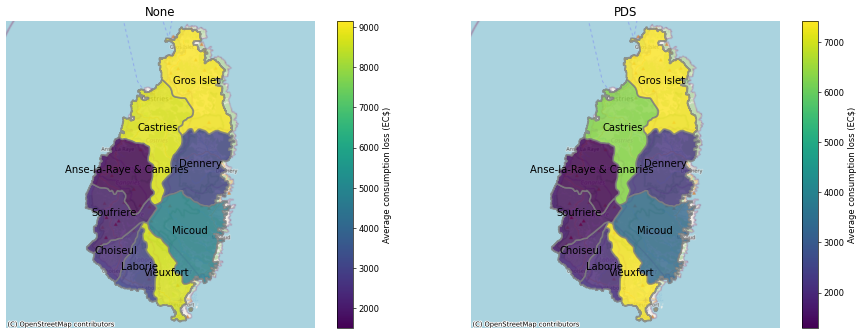

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# baseline.plot(column='None', 
#               cmap='viridis', 
#               legend=True, ax=ax[0], alpha=0.8, \
#               linewidth=2, edgecolor='0.5', \
#               legend_kwds={'label': 'Average consumption loss (EC$)'})
# policy.plot(column=policy_name, cmap='viridis', legend=True, ax=ax[1], alpha=0.8, linewidth=2, edgecolor='0.5', legend_kwds={'label': 'Average consumption loss (EC$)'})
# ax[0].set_title('None', fontsize=14)
# ax[1].set_title(policy_name, fontsize=14)
# # fig.suptitle('Mean consumption loss per household', fontsize=14)

# # Make the subplots more square-like
# xmin, ymin, xmax, ymax = gdf.total_bounds
# xmin -= 12500
# xmax += 12500
# ymin -= 1000
# ymax += 1000

# for i in range(0, 2):
#     ax[i].set_xlim(xmin, xmax)
#     ax[i].set_ylim(ymin, ymax)
#     ax[i].axis('off')
#     ctx.add_basemap(ax[i], source=ctx.providers.OpenStreetMap.Mapnik)

# # Add names of the districts to the map
# for i, txt in zip(gdf.index, gdf['NAME_1']):
#     ax[0].annotate(txt, (gdf['geometry'].centroid.x[i], gdf['geometry'].centroid.y[i]), ha='center', fontsize=12)
#     ax[1].annotate(txt, (gdf['geometry'].centroid.x[i], gdf['geometry'].centroid.y[i]), ha='center', fontsize=12)

# # # Add spacing between suptitle and titles
# fig.subplots_adjust(top=0.75)

# # Bring subplots closer to each other
# fig.subplots_adjust(wspace=0)

# # # Apply tight layout
# # fig.tight_layout()